### Business Problem 
> <b>Finding optimal number and location of warehouse to reduce cost and meet demand.</b>

<b>Introduction</b>

<i>Facility Location Problem</i> - optimization task aiming to determine the best among potential sites for warehouses or factories.

Original Problem - <a href="https://pubsonline.informs.org/doi/10.1287/mnsc.12.3.253">Balinski(1965)</a> minimizes the sum of two(annual) cost voices:
1. Transportation Costs
2. Warehouse Fixed Costs

<b>Transportation Cost</b>
<p>Expenses generated by reaching customers from the warehouse location.</p>

<b>Warehouse Fixed Costs</b>
<p>Its location specific : rent, taxes, electricity and maintenance.</p>

<b>Scenario</b>
<p>The goal of CFLP is to determine the number and location of warehouses that will meet the customers demand while reducing fixed and transportation costs.</p>

<p>Posing the business problem as minimization of the following objective function:</p>

<img src="https://miro.medium.com/v2/resize:fit:474/format:webp/1*Xk1PVKqwRQ1_9C5tiwVdMg.png" alt="Alternative text" />

- N : set of customer locations
- M : set of candidate warehouse locations
- fⱼ: represents annual fixed cost for warehouse
- tᵢⱼ: represents cost of transportation form warehouse j to customer i
- xᵢⱼ: number of units delivered from warehouse j to customer i
- yⱼ: is a binary variable yⱼ ∈ {0,1}, indicating whether the warehouse should be built in the location j(yⱼ = 1) or not (yⱼ = 0)

<p>Addition of <b>constraints</b> to the objective function</p>
<p>Modeling capacitated problem - each facility j can supply an annual maximum capacity Cⱼ, hence the number of units delivered to customer xᵢⱼcannot be greater than this value :</p>

<img src="https://miro.medium.com/v2/resize:fit:284/format:webp/1*NX-iATeZFSy7vra1B0Eq7w.png" alt="Alternative text" />

<p>Yearly units delivered from warehouse j to customer i must range between zero and dᵢ, the annual demand from customer i:</p>

<img src="https://miro.medium.com/v2/resize:fit:304/format:webp/1*hoA6J1498oImaPTqApRL0A.png" alt="Alternative text" />

<p>Meeting customer’s demand - each warehouse serving a customer location must fully meet its demand:</p>

<img src="https://miro.medium.com/v2/resize:fit:224/format:webp/1*g9xdZbsnM_mdHbyPkNOhVA.png" alt="Alternative text" />

<img src="https://miro.medium.com/v2/resize:fit:866/format:webp/1*pQa7oKoXukniTlOaXxgP-g.png" alt="Alternative text" />

### Needed libraries to be imported
- Numpy, Pandas for data manipulation
- math for mathematical functions
- GeoPandas for geospatial recommendations
- Matplotlib for data visualizations
- PuLP for optimization

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import geopandas
from math import sin, cos, asin, acos, radians

from pulp import LpProblem, LpMinimize, LpVariable, LpBinary, lpSum, lpSum, LpStatus, value

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Dataset 
Optimization problem in Italy

Source : <a href="https://simplemaps.com">SimpleMaps</a>

CSV File Link : <a href="https://simplemaps.com/data/it-cities">Italian Cities Database</a>

Interested in following columns :
- city : name of the town
- lat : latitude
- lng : longitude
- population : number of inhabitants
- capital : indicates whether the city is a chief town or administrative center
- admin_name : name of the [highest level administration region](https://en.wikipedia.org/wiki/Regions_of_Italy)

In [4]:
# Read the data
df = pd.read_csv('data/it.csv',
                usecols=['city','lat','lng','population',
                         'capital','admin_name'])

In [5]:
# Display the data
df

,city,lat,lng,admin_name,capital,population
0,Rome,41.8931,12.4828,Lazio,primary,2872800
1,Milan,45.4669,9.1900,Lombardy,admin,1366180
2,Naples,40.8333,14.2500,Campania,admin,966144
3,Turin,45.0667,7.7000,Piedmont,admin,870952
4,Palermo,38.1157,13.3613,Sicilia,admin,668405
...,...,...,...,...,...,...
3368,Sant’Eusanio del Sangro,42.1667,14.3333,Abruzzo,NaN,2471
3369,Cicagna,44.4085,9.2363,Liguria,NaN,2470
3370,Tollegno,45.5833,8.0500,Piedmont,NaN,2469
3371,Revere,45.0572,11.1302,Lombardy,NaN,2468


### Customer, Warehouse and Demand
While creating customers, facility and demand, certain assumptions to take into consideration :
1. Customers are a fraction (30%) of the input cities.

2. Facilities can be established only in administrative centers with a starting condition to build warehouses in 80% of the Italian chief towns.

3. Demand is constant and known through the year and it is equal to a fraction(2%) of the population of the customers’ town plus an error term.

In [6]:
RANDOM_STATE = 2 # for reproducibility
FRACTION_CUSTOMERS = 0.3 # fraction of cities we want to keep as customers
FRACTION_WAREHOUSES = 0.8 # fraction of cities we want to keep as warehouse locations
FRACTION_DEMAND = 0.02 # fraction of citizens of a city that may order a product

# List of the 20 regions of Italy 
REGION_LIST = ['Lombardy', 'Veneto', 'Emilia-Romagna', 'Sicilia', 'Campania', 'Piedmont', 'Puglia', 
    'Lazio', 'Calabria', 'Tuscany', 'Sardegna', 'Marche', 'Friuli-Venezia Giulia', 'Abruzzo',
    'Umbria', 'Trentino-Alto Adige', 'Liguria', 'Basilicata', 'Molise', 'Valle d’Aosta']

# Demand is composed of :
# a. A fraction of the population
# b. An error term of uniform distribution
# Note : demand is approximated to the closest int
# as its physical meaning denies decimals
df['demand'] = np.floor(
    FRACTION_DEMAND * df.population + np.random.uniform(-10, 10, size=(df.shape[0],)))

# Create the warehouse dataframe :
# a. Filter the 20 regions of Italy
# b. Filter capitals as candidate warehouse locations
# c. Sample a fraction of the original cities
facility_df = df.\
                loc[df.admin_name.isin(REGION_LIST)].\
                loc[df.capital.isin(['admin', 'minor'])].\
                sample(frac=FRACTION_WAREHOUSES, random_state=RANDOM_STATE, ignore_index=True)

# Create the customer dataframe :
# a. Filter the 20 regions of Italy
# b. Sample a fraction of the original cities
customer_df = df.\
                loc[df.admin_name.isin(REGION_LIST)].\
                sample(frac=FRACTION_CUSTOMERS, random_state=RANDOM_STATE, ignore_index=True)

# Customers IDs list 
customer_df['customer_id'] = range(1, 1 + customer_df.shape[0])

Note : in the online dataset - the region name Valle d’Aosta contains a typographic (curved) apostrophe (U+2019) instead of the typewriter (straight) apostrophe (U+0027)

To observe our locations on a map - we can geopandas by creating GeoDataFrame enriched with geospatial information using the points_from_xy method 

In [8]:
def add_geocoordinates(df, lat='lat', lng='lng'):
    '''
    Add column "geometry" with <shapely.geometry.point.Point> 
    objects built from latitude and longitude values 
    in the input dataframe
    
    Args:
        - df: input dataframe
        - lat: name of the column containing the latitude (default: lat)
        - lng: name of the column containing the longitude (default: lng)
    Out:
        - df: same dataframe enriched with a geo-coordinate column
    '''
    assert pd.Series([lat, lng]).isin(df.columns).all(),\
        f'Cannot find columns "{lat}" and/or "{lng}" in the input dataframe.'
    return geopandas.GeoDataFrame(df,
                                 geometry=geopandas.points_from_xy(df.lng, df.lat))

customer_df = add_geocoordinates(customer_df)
facility_df = add_geocoordinates(facility_df)

Access the map of Italy through geopandas and plot customers and potential warehouse locations.

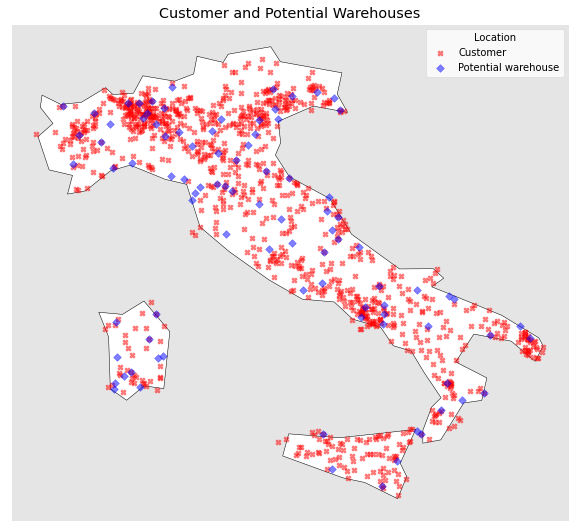

In [10]:
# Prepare country plot
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Extract and plot the shape of Italy
italy = world[world.name == 'Italy']
ax = italy.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot customers as points
customer_df.\
    plot(ax=ax, marker='X', color='red', markersize=30, alpha=0.5, label='Customer')

# Plot potential facility locations as points
facility_df.\
    plot(ax=ax, marker='D', color='blue', markersize=30, alpha=0.5, label='Potential warehouse')

# Add legend
plt.legend(facecolor='white', title='Location')

# Add title
plt.title('Customer and Potential Warehouses')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

Observe the average demand for each of the 20 Italian regions

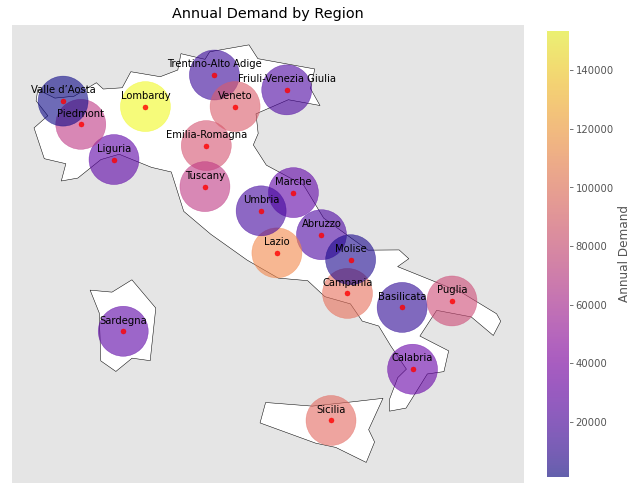

In [11]:
# Prepare region dataframe:
#   a. Filter the 20 regions of Italy
#   b. Group by region
#   c. Calculate:
#     - Mean regional latitude
#     - Mean regional longitude
#     - Sum of regional demand
region_df = df.\
             loc[df.admin_name.isin(REGION_LIST)].\
             groupby(['admin_name']).\
             agg({'lat': 'mean', 'lng': 'mean', 'demand': 'sum'}).\
             reset_index()

# Add geo-coordinates
region_df = add_geocoordinates(region_df)

# Plot the shape of Italy
ax = italy.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot region area colored based on demand
region_df.\
    plot(ax=ax, column='demand', marker='o', c='demand', cmap='plasma', markersize=2500, alpha=0.6)

# Add region 'center' as red dots
region_df.\
    plot(ax=ax, marker='o', c='red', markersize=25, alpha=0.8, label='Customer location')

# Add region name above the center
for i, row in region_df.iterrows():
    plt.annotate(
        row.admin_name, xy=(row.lng, row.lat+0.2), horizontalalignment='center')

# Add color bar with demand scale
plt.colorbar(ax.get_children()[1], ax=ax, label='Annual Demand', fraction=0.04, pad=0.04) 

# Add title
plt.title('Annual Demand by Region')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

Store demand data in a dictionary of customer-demand pairs

In [13]:
# Dictionary of cutomer id (id) and demand (value)
demand_dict = {customer : customer_df['demand'][i] for i, customer in enumerate(customer_df['customer_id'])}

### Supply & Fixed Cost 
To model supply and fixed cost certain assumptions to consider :
1. Each warehouse can meet a maximum yearly supply equal to 3 times the average regional demand.

2. Each warehouse has a constant annual fixed cost of 100.000,00 €, independently from its location.

In [14]:
# Assumptions: 
# a. Each warehouse has an annual cost of 100.000,00 euros: rent, electricity, ...
# b. Each warehouse can meet 3 times the regional average annual demand
COST_PER_WAREHOUSE = 100_000
SUPPLY_FACTOR_PER_WAREHOUSE = 3
SUPPLY_PER_WAREHOUSE = region_df.demand.mean() * SUPPLY_FACTOR_PER_WAREHOUSE

# Warehouses list
facility_df['warehouse_id'] = ['Warehouse ' + str(i) for i in range(1, 1 + facility_df.shape[0])]

# Dictionary of warehouse id (id) and max supply (value)
annual_supply_dict = { warehouse : SUPPLY_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

# Dictionary of warehouse id (id) and fixed costs (value)
annual_cost_dict = { warehouse : COST_PER_WAREHOUSE for warehouse in facility_df['warehouse_id'] }

### Transportation Cost
To estimate transportation cost :
1. The distance between different locations

2. a cost function per unit of distance

Approximate distance between two locations on a spherical surface using <a href="https://en.wikipedia.org/wiki/Haversine_formula">Haversine Formula</a>.

In [15]:
def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Calculate distance between two locations given latitude and longitude.

    Args:
       - lat1: latitude of the first location
       - lon1: longitude of the first location
       - lat2: latitude of the second location
       - lon2: longitude of the second location
    Out:
       - Distance in Km
    
    Ref: 
       - https://en.wikipedia.org/wiki/Haversine_formula
    '''
    return 6371.01 *\
            acos(sin(radians(lat1))*sin(radians(lat2)) +\
            cos(radians(lat1))*cos(radians(lat2))*cos(radians(lon1)-radians(lon2)))

Lets try it on two cities :
- Milano (latitude: 45.4654219, longitude: 9.18854)
- Bergamo (latitude: 45.695000, longitude: 9.670000)

In [16]:
haversine_distance(45.4654219, 9.18854, 45.695000, 9.670000)

45.33976414594754

The above distance 45.3 Km is a reasonable approximation since routes are not take into account.

Convert distance in a measure of cost.
At the moment, the :
- avg price of gasoline in Italy : 1.847 €/L(https://www.cargopedia.net/europe-fuel-prices)
- avg consumption of an EURO VI truck : 0.38 L/Km(https://www.transportenvironment.org/wp-content/uploads/2021/07/2015_06_Comparing_US_EU_truck_fuel_economy_explantory_note_Final.pdf)
- estimated avg cost : 0.70186 € per Km traveled on the Italian soil

In [17]:
def traveling_cost(distance_in_km):
    '''
    Return traveling cost in euros given a distance in Km.

    Args:
      - distance_in_km: travel distance in Km
    Out:
      - cost of the trip in euros
    '''
    return 0.70186 * distance_in_km

Calculate traveling costs for each warehouse-customer pair and store them in dictionary.

In [19]:
# Dict to store the distances between all warehouses and customers
transport_costs_dict = {}

# For each warehouse location
for i in range(0, facility_df.shape[0]):
    
    # Dict to store the distances between the i-th warehouse and all customers
    warehouse_transport_costs_dict = {}
    
    # For each customer location
    for j in range(0, customer_df.shape[0]):
        
        # Distance in Km between warehouse i and customer j
        d = 0 if facility_df.city[i]==customer_df.city[j] else haversine_distance(
            facility_df.lat[i], facility_df.lng[i], customer_df.lat[j], customer_df.lng[j])
        
        # Update costs for warehouse i
        warehouse_transport_costs_dict.update({customer_df.customer_id[j]: traveling_cost(d)})
    
    # Final dictionary with all costs for all warehouses
    transport_costs_dict.update({facility_df.warehouse_id[i]: warehouse_transport_costs_dict})

### Optimization
Define the two decision variable, the objective function and constraints as follow :
<img src="https://miro.medium.com/v2/resize:fit:866/format:webp/1*pQa7oKoXukniTlOaXxgP-g.png" alt="Alternative text" />

In [20]:
# Define linear problem
lp_problem = LpProblem('CFLP', LpMinimize)


# Variable: y_j (constraint: it is binary)
created_facility = LpVariable.dicts(
    'Create_facility', facility_df['warehouse_id'], 0, 1, LpBinary)

# Variable: x_ij
served_customer = LpVariable.dicts(
    'Link', [(i,j) for i in customer_df['customer_id'] for j in facility_df['warehouse_id']], 0)


# Objective function 
objective = lpSum(annual_cost_dict[j]*created_facility[j] for j in facility_df['warehouse_id']) +\
            lpSum(transport_costs_dict[j][i]*served_customer[(i,j)] \
                  for j in facility_df['warehouse_id'] for i in customer_df['customer_id'])

lp_problem += objective

# Costraint: the demand must be met
for i in customer_df['customer_id']:
    lp_problem += lpSum(served_customer[(i,j)] for j in facility_df['warehouse_id']) == demand_dict[i]

# Constraint: a warehouse cannot deliver more than its capacity limit
for j in facility_df['warehouse_id']:
    lp_problem += lpSum(served_customer[(i,j)] for i in customer_df['customer_id']) <= annual_supply_dict[j] * created_facility[j]

# Constraint: a warehouse cannot give a customer more than its demand
for i in customer_df['customer_id']:
    for j in facility_df['warehouse_id']:
        lp_problem += served_customer[(i,j)] <= demand_dict[i] * created_facility[j]

In [21]:
# Solve the optimization problem
lp_problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/jessica/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/t6/qbm3gwsd3vgcgyyndxlh_h1w0000gn/T/c7f0c39b09964b9dbedf53ff4f982d9e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/t6/qbm3gwsd3vgcgyyndxlh_h1w0000gn/T/c7f0c39b09964b9dbedf53ff4f982d9e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 93016 COLUMNS
At line 552906 RHS
At line 645918 BOUNDS
At line 646010 ENDATA
Problem MODEL has 93011 rows, 92001 columns and 367731 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8.8927e+06 - 0.45 seconds
Cgl0004I processed model has 93011 rows, 92001 columns (91 integer (91 of which binary)) and 367731 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 2.66454e-15
Cbc0038I Solution found of 8.8927e+06
Cbc0038I Relaxing con

1

In [22]:
# Check the outcome
print('Solution: ', LpStatus[lp_problem.status])

Solution:  Optimal


Explore decision variables : How many warehouses do we need?
In what locations?

### Explore the results

In [23]:
# Business goal : minimize costs
# objective function
value(lp_problem.objective)

8892700.404329153

This is the minimum possible cost achieved under the given constraints.

In [24]:
# Decision Variable : using varValue 
# yⱼ for j = Warehouse 1
created_facility['Warehouse 1'].varValue

1.0

As yⱼ = 1, we should establish a warehouse in that location.

In [25]:
## Count number of needed facilities:
# List of the values assumed by the binary variable created_facility
facility_values = [i.varValue for i in created_facility.values()]

# Count of each distinct value of the list
[[i, facility_values.count(i)] for i in set(facility_values)]

[[0.0, 59], [1.0, 32]]

It is sufficient to <b>build just 32 of the initially budgeted 91 sites<b>. 

In [27]:
# Save the decison variablein the initial dataframe
# and observe the chosen location -

# Create dataframe column to store whether to build the warehouse or not 
facility_df['build_warehouse'] = ''

# Assign Yes/No to the dataframe column based on the optimization binary variable
for i in facility_df['warehouse_id']:
    if created_facility[i].varValue == 1:
        print('Build site at: ', i)
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'Yes'
    else:
        facility_df.loc[facility_df['warehouse_id'] == i, 'build_warehouse'] = 'No'

Build site at:  Warehouse 1
Build site at:  Warehouse 2
Build site at:  Warehouse 3
Build site at:  Warehouse 4
Build site at:  Warehouse 7
Build site at:  Warehouse 8
Build site at:  Warehouse 16
Build site at:  Warehouse 18
Build site at:  Warehouse 20
Build site at:  Warehouse 21
Build site at:  Warehouse 22
Build site at:  Warehouse 23
Build site at:  Warehouse 25
Build site at:  Warehouse 26
Build site at:  Warehouse 27
Build site at:  Warehouse 29
Build site at:  Warehouse 33
Build site at:  Warehouse 35
Build site at:  Warehouse 38
Build site at:  Warehouse 48
Build site at:  Warehouse 49
Build site at:  Warehouse 55
Build site at:  Warehouse 56
Build site at:  Warehouse 57
Build site at:  Warehouse 58
Build site at:  Warehouse 63
Build site at:  Warehouse 66
Build site at:  Warehouse 70
Build site at:  Warehouse 74
Build site at:  Warehouse 82
Build site at:  Warehouse 83
Build site at:  Warehouse 84


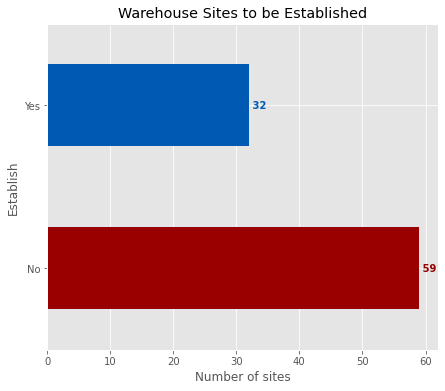

In [28]:
colors = ['#990000', '#0059b3']

facility_df.build_warehouse.value_counts().plot.barh(
  title='Warehouse Sites to be Established', xlabel='Number of sites', color=colors, ylabel='Establish', figsize=(7,6)) 

for i, v in enumerate(facility_df.build_warehouse.value_counts()):
    plt.text(v, i, ' '+str(round(v,3)), color=colors[i], va='center', fontweight='bold')

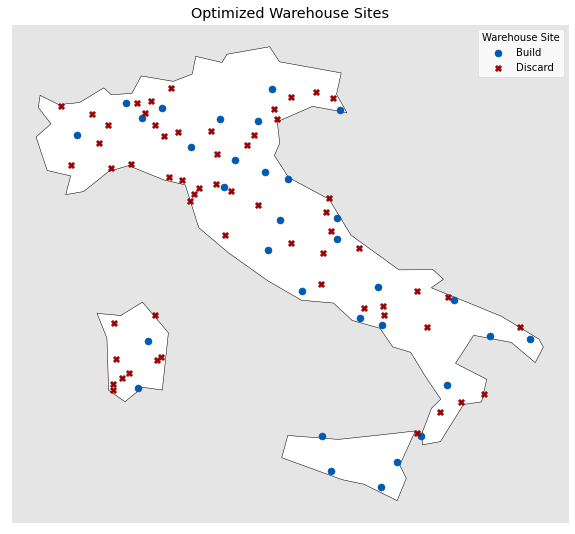

In [29]:
# Plot the shape of Italy
ax = italy.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot sites to establish
facility_df.\
    loc[facility_df.build_warehouse =='Yes'].\
    plot(ax=ax, marker='o', c='#0059b3', markersize=50, label='Build')

# Plot sites to discard
facility_df.\
    loc[facility_df.build_warehouse =='No'].\
    plot(ax=ax, marker='X', c='#990000', markersize=40, label='Discard')

# Add title
plt.title('Optimized Warehouse Sites')

# Add legend
plt.legend(title='Warehouse Site', facecolor='white')

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()

Find the customers served by each warehouse in the optimized solution.

In [30]:
def get_linked_customers(input_warehouse):
    '''
    Find customer ids that are served by the input warehouse.
    
    Args:
        - input_warehouse: string (example: <Warehouse 21>)
    Out:
        - List of customers ids connected to the warehouse
    '''
    # Initialize empty list
    linked_customers = []
    
    # Iterate through the xij decision variable
    for (k, v) in served_customer.items():
            
            # Filter the input warehouse and positive variable values
            if k[1]==input_warehouse and v.varValue>0:
                
                # Customer is served by the input warehouse
                linked_customers.append(k[0])

    return linked_customers

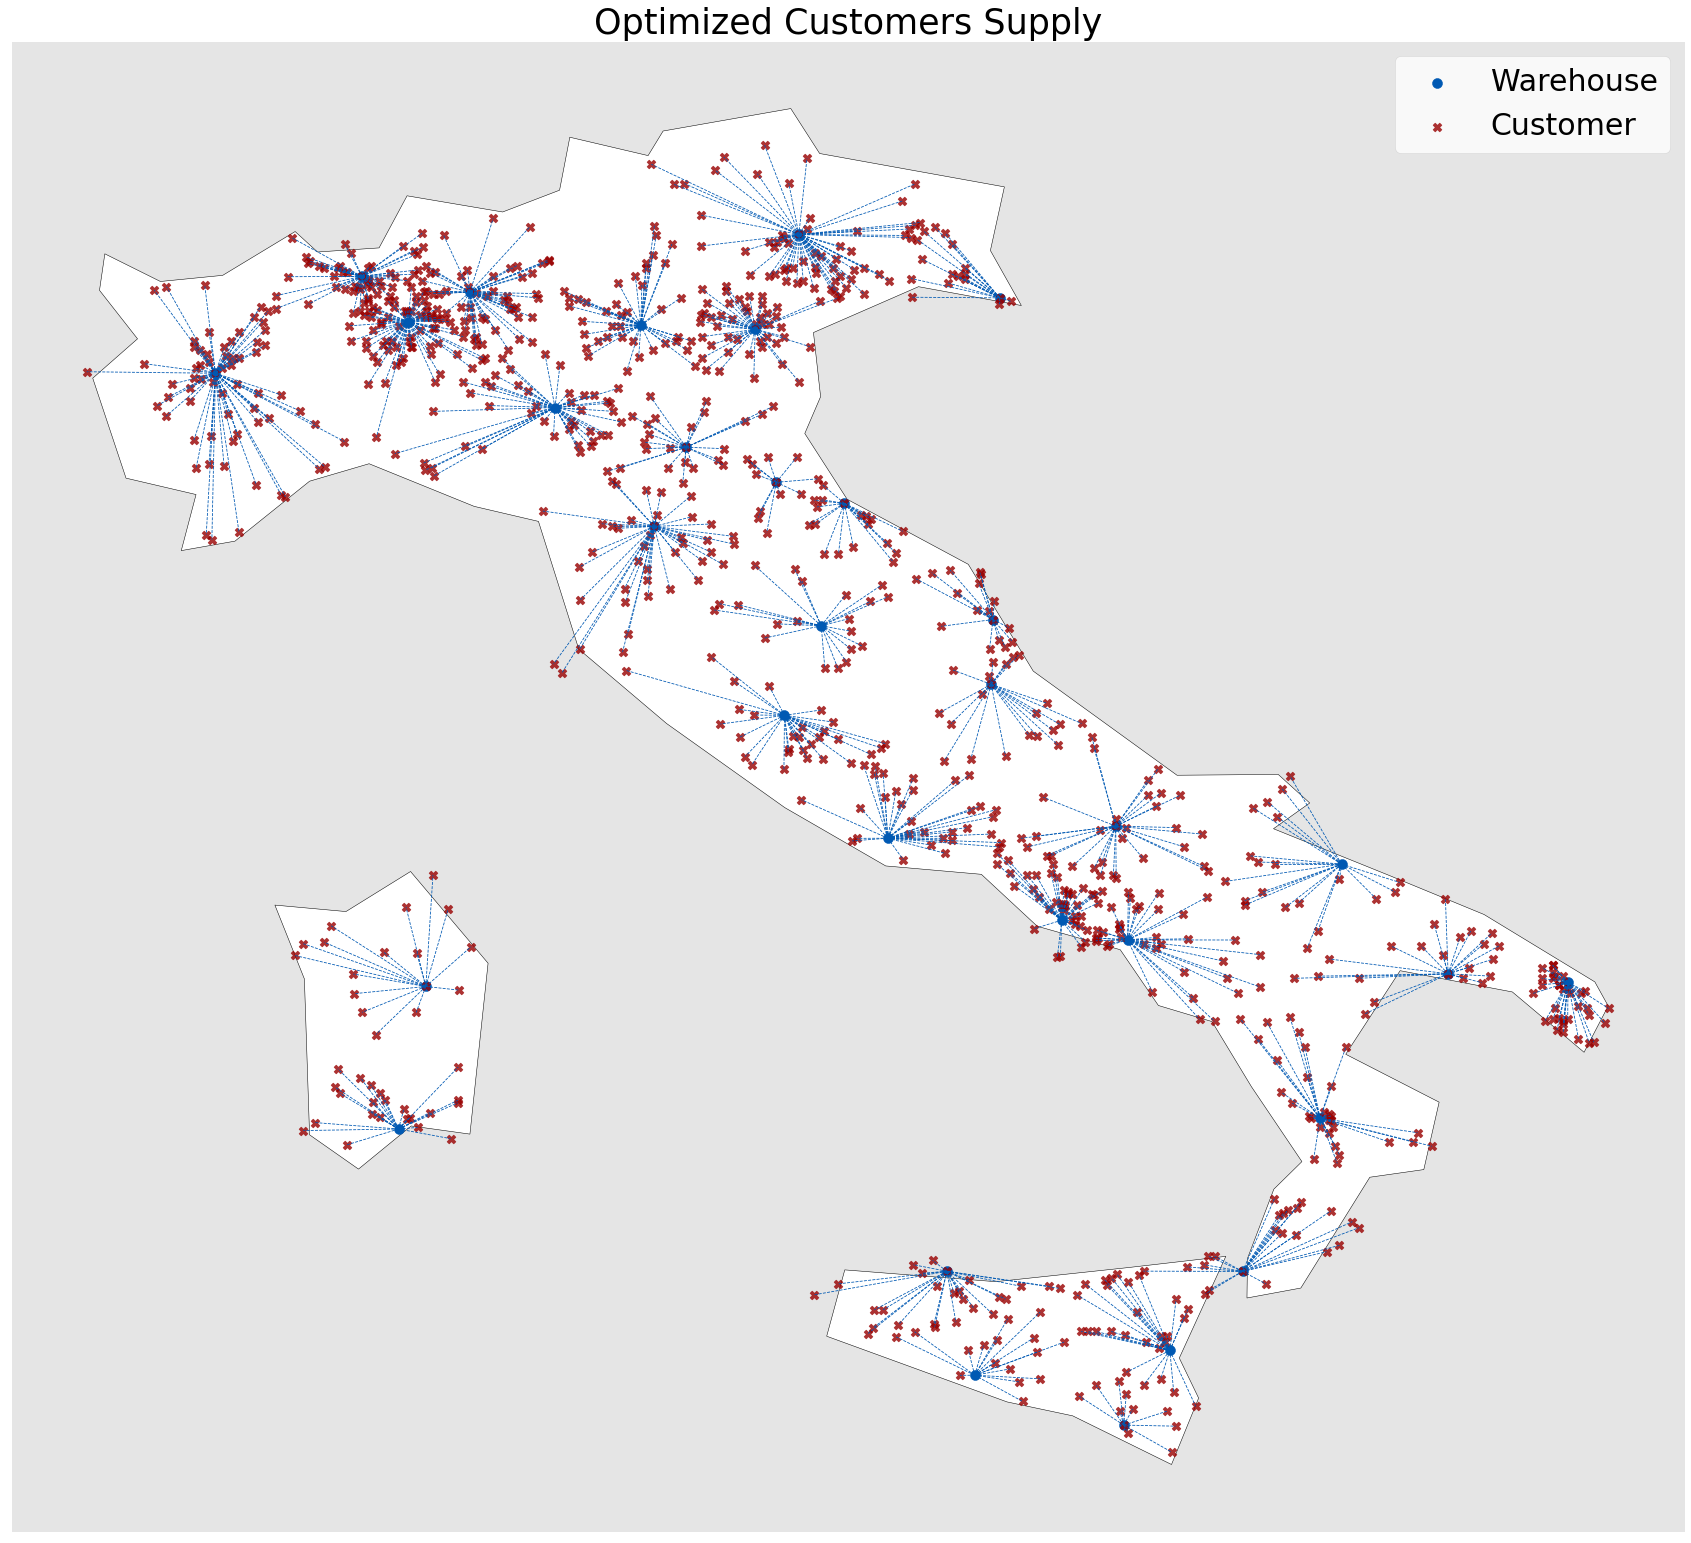

In [31]:
# Warehouses to establish
establish = facility_df.loc[facility_df.build_warehouse =='Yes']

# Plot the shape of Italy
ax = italy.plot(color='white', edgecolor='black', figsize=(30, 30))

# Plot sites to establish
establish.\
    plot(ax=ax, marker='o', c='#0059b3', markersize=100, label='Warehouse')

# Plot customers
customer_df.\
    plot(ax=ax, marker='X', color='#990000', markersize=80, alpha=0.8, label='Customer')

# For each warehouse to build
for w in establish.warehouse_id:

    # Extract list of customers served by the warehouse
    linked_customers = get_linked_customers(w)

    # For each served customer
    for c in linked_customers:
    
        # Plot connection between warehouse and the served customer
        ax.plot(
         [establish.loc[establish.warehouse_id==w].lng, customer_df.loc[customer_df.customer_id==c].lng],
         [establish.loc[establish.warehouse_id==w].lat, customer_df.loc[customer_df.customer_id==c].lat],
         linewidth=0.8, linestyle='--', color='#0059b3')

# Add title
plt.title('Optimized Customers Supply', fontsize = 35)

# Add legend
plt.legend(facecolor='white', fontsize=30)

# Remove ticks from axis
plt.xticks([])
plt.yticks([])

# Show plot
plt.show()